## Question 3: Hierarchical Clustering

In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np

In [2]:
# reading the processed data in pandas dataframe
football = pd.read_csv('processed_data.csv', index_col=0)

### Further filtering our data to extract only numerical attributes for Clustering. Also, we drop the 'ID' column in dataframe as it does not help in the clustering process.

In [3]:
# Step 1: Extract numerical features
data = football.select_dtypes(include=[np.number])
# removing ordinal feature 'ID'
data.drop('ID', axis=1, inplace=True)

C:\Users\Shivprasad\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
data.head()

,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,...,processed_LWB,processed_LDM,processed_CDM,processed_RDM,processed_RWB,processed_LB,processed_LCB,processed_CB,processed_RCB,processed_RB
0,31,94,94,2202,5.0,4.0,4.0,10.0,84.0,95.0,...,64.000000,61.000000,61.000000,61.000000,64.000000,59.000000,47.000000,47.000000,47.000000,59.000000
1,33,94,94,2228,5.0,4.0,5.0,7.0,84.0,94.0,...,65.000000,61.000000,61.000000,61.000000,65.000000,61.000000,53.000000,53.000000,53.000000,61.000000
2,26,92,93,2143,5.0,5.0,5.0,10.0,79.0,87.0,...,65.000000,60.000000,60.000000,60.000000,65.000000,60.000000,47.000000,47.000000,47.000000,60.000000
3,27,91,93,1471,4.0,3.0,1.0,1.0,17.0,13.0,...,57.513274,56.825146,56.825146,56.825146,57.513274,56.806786,55.614626,55.614626,55.614626,56.806786
4,27,91,92,2281,4.0,5.0,4.0,7.0,93.0,82.0,...,77.000000,77.000000,77.000000,77.000000,77.000000,73.000000,66.000000,66.000000,66.000000,73.000000


### Part 1: Agglomerative Clustering
We use sklearn library which has implementation of agglomerative clustering algorithm.

In [10]:
# imports
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
from sklearn import metrics

In [6]:
X = data    # creating a copy of data for reuse

In [7]:
# Scaling the data so that all the features become comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
  
# Normalizing the data so that the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)

# Applying dimensionality reduction to the data using Principal Component Analysis (to help visluzaize the plots ahead)
# # comment following code if you don't want to use the PCA algorithm
# pca = PCA(n_components=2)
# X_principal = pca.fit_transform(X_normalized)
# X_principal = pd.DataFrame(X_principal)
# X_principal.columns = ['P1', 'P2']

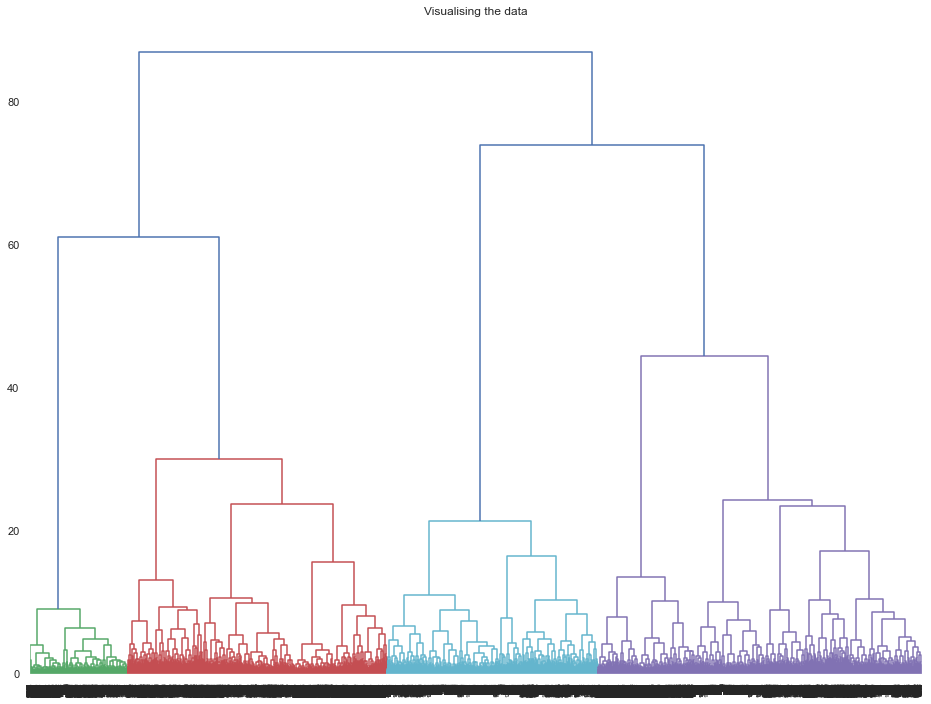

In [11]:
plt.figure(figsize =(16, 12))
plt.title('Visualising the data')
Dendrogram = shc.dendrogram((shc.linkage(X_normalized, method ='ward')))

#### using the dendrogram above, we can infer that optimal number of clusters can be 2 or 4. Checking the cluster quality with both of these values


In [8]:
ac2 = AgglomerativeClustering(n_clusters = 2)
ac2_result = ac2.fit_predict(X_normalized)

In [9]:
# checking the labels for first 10 samples
ac2_result[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int64)

### The following plots are visualized only on the 2-d data (X_principal) which is obtained by dimensionality reduction of our original data. It is just for visualizatin purpose. For dendrogramming purposes and calculating Silhoutee score, we have considered whole set of 75 features in data i.e. X_normalized. If you want to run the cells of plots below, plz perform PCA by uncommenting PCA code above.

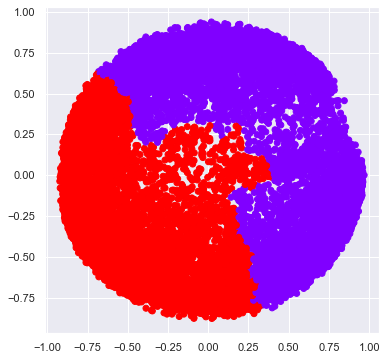

In [23]:
# Visualizing the clustering
ac2_pca = AgglomerativeClustering(n_clusters = 2)
ac2_pca_result = ac2.fit_predict(X_principal)
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = ac2_pca_result, cmap ='rainbow')
plt.show()

In [12]:
ac4 = AgglomerativeClustering(n_clusters = 4)
ac4_result = ac4.fit_predict(X_normalized)

In [21]:
ac4_result[:10]

array([0, 0, 0, 3, 0, 0, 0, 0, 2, 3], dtype=int64)

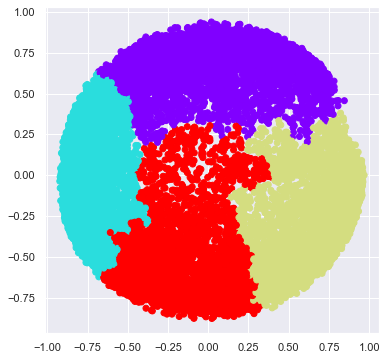

In [24]:
# Visualizing the clustering
ac4_pca = AgglomerativeClustering(n_clusters = 2)
ac4_pca_result = ac4.fit_predict(X_principal)
plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], c = ac4_pca_result, cmap ='rainbow')
plt.show()

## Part 2: Divisive clustering

In [26]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.image as img

In [27]:
class DivisiveClustering:
	def __init__(self):
		self.clusters={}
		self.dist_matrix=None
		self.mapping=None
		self.no_clusters=0
		self.linkage_matrix=None
		self.n=None
		self.hierarchical_clusters={}
		self.last_index=None

	def initialize(self):
		self.n=len(self.mapping)
		self.last_index=2*self.n-2
		self.i=0
		self.clusters[self.last_index]=list(self.mapping.keys())
		self.linkage_matrix=np.zeros([self.n-1, 4])

	def splinter(self):
		cluster_diameters={k:(len(v)<1)*(-1)+(len(v)>1)*np.max(self.dist_matrix[np.ix_(v,v)]) for k,v in self.clusters.items()}
		max_diameter_cluster=max(cluster_diameters, key=cluster_diameters.get)
		avg_within_cluster_distances={pt:(np.sum(self.dist_matrix[np.ix_(self.clusters[max_diameter_cluster], [pt])])/(len(self.clusters[max_diameter_cluster])-1)) for pt in self.clusters[max_diameter_cluster]}
		splinter_element=max(avg_within_cluster_distances, key=avg_within_cluster_distances.get)
		self.no_clusters+=1
		return splinter_element, max_diameter_cluster

	def reassign(self, splinter_element, orig_cluster_key):
		# Create temp clusters
		temp_new_cluster=[splinter_element]
		self.clusters[orig_cluster_key].remove(splinter_element)
		temp_orig_cluster=self.clusters[orig_cluster_key]

		# Remove orig cluster from cluster dict
		del self.clusters[orig_cluster_key]

		# Calculate distances
		within_cluster_dist={pt:np.mean(self.dist_matrix[np.ix_(temp_orig_cluster,[pt])]) for pt in temp_orig_cluster }
		dist_to_splinter={pt:self.dist_matrix[pt, splinter_element]  for pt in temp_orig_cluster}
		dist_diff={pt:(within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in temp_orig_cluster} # if +ve, move to splinter
		
		# Reassign points
		for pt in temp_orig_cluster:
			if dist_diff[pt]>0 and len(temp_orig_cluster)>1:
				temp_new_cluster.append(pt)
				temp_orig_cluster.remove(pt)
		
		dist_bw_clusters=np.max(self.dist_matrix[np.ix_(temp_orig_cluster, temp_new_cluster)])
		
		# Add temp clusters to cluster dict
		if len(temp_orig_cluster)==1:
			self.clusters[temp_orig_cluster[0]]=temp_orig_cluster
			orig_cluster_key=temp_orig_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_orig_cluster
			orig_cluster_key=self.last_index

		if len(temp_new_cluster)==1:
			self.clusters[temp_new_cluster[0]]=temp_new_cluster
			new_cluster_key=temp_new_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_new_cluster
			new_cluster_key=self.last_index

		# Append to hierarchical clusters
		self.hierarchical_clusters['iter_'+str(self.no_clusters)]=copy.deepcopy(self.clusters)

		# Make the linkage function
		self.make_linkage_function(new_cluster_key, orig_cluster_key, dist_bw_clusters, len(temp_new_cluster)+len(temp_orig_cluster))

	def make_linkage_function(self, cluster_1, cluster_2, dist, len_cluster_2):
		self.linkage_matrix[self.n-self.no_clusters-1, 0]=cluster_2
		self.linkage_matrix[self.n-self.no_clusters-1, 1]=cluster_1
		self.linkage_matrix[self.n-self.no_clusters-1, 2]=dist
		self.linkage_matrix[self.n-self.no_clusters-1, 3]=len_cluster_2

	def termination(self):
		for k, v in self.clusters.items():
			if len(v)>1:
				return 0
		return 1

	def fit(self, dist_matrix, mapping):
		self.dist_matrix=dist_matrix
		self.mapping=mapping
		self.initialize()
		while not self.termination():
			splinter_element, orig_cluster_key=self.splinter()
			self.reassign(splinter_element, orig_cluster_key)
		print('Clustering done!')

	def create_dendrogram(self):
		fig=plt.figure(figsize=(18, 8))
		plt.title("Dendrogram - Divisive Clustering")
		labels=['temp']*len(self.mapping)
		for idx,label in self.mapping.items():
			labels[idx]=label
		labels=np.array(labels)
		dendrogram(self.linkage_matrix, orientation='top', labels=labels)
		fig.savefig('dendrogram_divisive.png')
		plt.show()

In [28]:
if __name__=='__main__':
    #defining mapping
    mapping={k:k for k in range(len(data))}
    
    X = data
    # Scaling the data so that all the features become comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Normalizing the data so that the data approximately follows a Gaussian distribution
    X_normalized = normalize(X_scaled)
    
    dist_matrix = cdist(X_normalized, X_normalized, metric='euclidean')
    print("dist_marix calculated. Shape: ", dist_matrix.shape)

    model=DivisiveClustering()
    model.fit(dist_matrix, mapping)
    print("model fitted. creating dendrogram")
    model.create_dendrogram()

dist_marix calculated. Shape:  (18207, 18207)


### Above code takes around 2-3 hours to complete the execution. Displaying the already computed dendrogram image results.

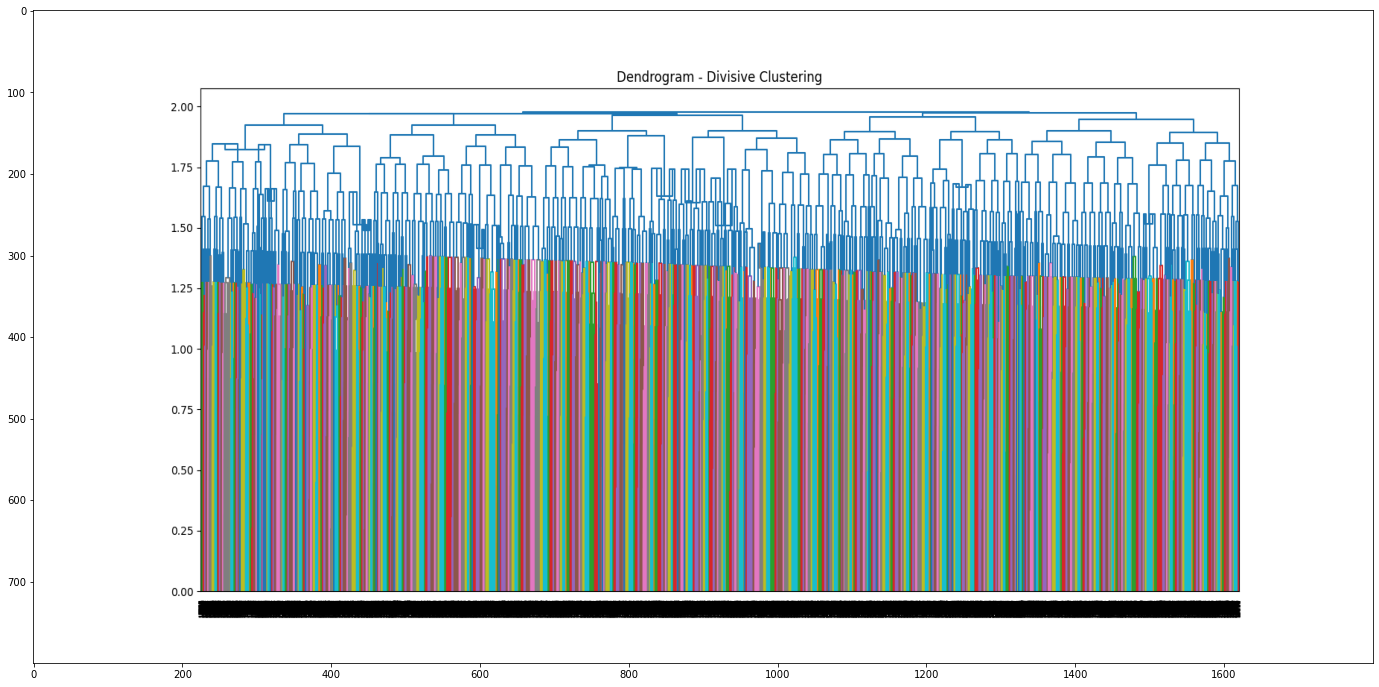

In [8]:
# reading png image file
im = img.imread('dendrogram_divisive.png')
  
# show image
fig, ax = plt.subplots(figsize=(24, 12))
ax.imshow(im, aspect='auto')

### Cluster Analysis

Comparing the cluster quality with k=2 and k=4

The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

* a: The mean distance between a sample and all other points in the same class.

* b: The mean distance between a sample and all other points in the next nearest cluster.

In [ ]:
print("Silhoutee result for k=2: ", silhouette_score(X_normalized, ac2_result))
print("Silhoutee result for k=4: ", silhouette_score(X_normalized, ac4_result))


Silhoutee result for k=2:  0.2083626440116968
Silhoutee result for k=4:  0.24990771240221585


### Thus, we can infer from Silhoutee score that clustering is better with k=4 here.

If the ground truth labels are not known, the Calinski-Harabasz index- also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

In [ ]:
# Checking the Calinski-Harabasz Index with above clstering labels.
print(metrics.calinski_harabasz_score(X_normalized, ac2_result))
print(metrics.calinski_harabasz_score(X_normalized, ac4_result))

4814.132032769332
5244.270359588634


the Davies-Bouldin index can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [69]:
# Checking the davies_bouldin Index with above clstering labels.
print(metrics.davies_bouldin_score(X_normalized, ac2_result))
print(metrics.davies_bouldin_score(X_normalized, ac4_result))

1.8664292286945656
1.30480411450543


## Determining the most similar attributes of the cluster.

In [ ]:
df = data

In [ ]:
df['ac2_result'] = ac2_result

<ipython-input-62-71ac7b67bed1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ac2_result'] = ac2_result


In [ ]:
df['ac2_result'].value_counts()

0    10897
1     7310
Name: ac2_result, dtype: int64

In [ ]:
df_0 = df[df['ac2_result']==0]
df_1 = df[df['ac2_result']==1]

In [ ]:
for column in data.columns:
    print("Mean values for feature ", column, " across 2 clusters are: ")
    print(df_0[column].mean())
    print(df_1[column].mean())

#### From above analysis of mean values of different features across the two clusters, we can easily identify the features which show a lot of variance in the values, and hence are the differentiating factors across the two clusters. Such features with their mean values are as follows:
* Mean values for feature  Special  across 2 clusters are: \
1735.5880517573644 AND
1392.4243502051984
* Mean values for feature  Skill Moves  across 2 clusters are: \
2.7640635037166192 AND
1.760922408374905
* Mean values for feature  Finishing  across 2 clusters are: \
58.014132329999086 AND
26.972016928440837
* Mean values for feature  Volleys  across 2 clusters are: \
53.33587225841975 AND
27.365750101192283
* Mean values for feature  LongShots  across 2 clusters are: \
58.812884280077085 AND
29.664470411049873
* Mean values for feature  Positioning  across 2 clusters are: \
61.722033587225845 AND
32.422572768633046
* Mean values for feature  processed_value  across 2 clusters are: \
3412.0225750206478 AND
918.0205198358414
* Mean values for feature  processed_release_clause  across 2 clusters are: \
6371.322779508805 AND
1922.2846860106215

From the stark variation in the values of thesvariables, we can label the clusters acordingly. For eg. the processed value of 1st cluster is 3412 whereas that of second cluster is 918. Hence we can say that first cluster is of players which high market brand value than second. Similarly, the skills like finishing, volley, longshot, and positioning, show the similar trend. Cluster 1 has high value for most of these skills indicating that more superior and technically skilled players are included in cluster 1.